In [ ]:
#TODO: riorganizzare le classi da 0 a 6
# inserirse svm
# inserire naive bayes
# implementare XGB

# ML algorithm for pattern classification
This notebook contains the definitions and training pipeline of the machine learning algorithms applied in the paper.
For each algorithm, a model will be created with the same hyperparameters as the ones declared in the paper (defaults hyperparameters of <code>sklearn</code>).

Said model will be trained and tested on the split already provided from the beginning of the SeqScout procedure. In this way, we can have a score that is as much as comparable as possible with the values reported by the paper.


Then, an hyperparameter search will be conducted on the models via cross validation on the training split. The best performing model will be again trained on the full train set and tested on test set, in order to compare it to the default model.
Each model will be compared on accuracy, precision and recall. Moreover, the confusion matrix for each best performing model will be produced.

## Major differences
Aside from the machine learning library employed, the presented algorithms differ from the original paper in a couple of aspects:
- They use the OneVsRest classifier for each model, while we use directly the multiclass classifier (except for the LinearSVC). This allows to save time on the model training and consequently on the hyperparameter search.
- The results will be computed on a single test split equal to a fifth of the original dataset. This split follows the same split employed for k-fold evaluation in the original paper. This choice was made considering the high overhead required when computing the patterns.
- As SVM model, pyspark has only the LinearSVC implemented, thus it will be used in place of SVC.

In [5]:
!pip freeze

anyio==3.6.2
argon2-cffi==21.3.0
argon2-cffi-bindings==21.2.0
asttokens==2.1.0
attrs==21.2.0
Automat==20.2.0
Babel==2.8.0
backcall==0.2.0
bcrypt==3.2.0
beautifulsoup4==4.11.1
bleach==5.0.1
blinker==1.4
certifi==2020.6.20
cffi==1.15.1
chardet==4.0.0
click==8.0.3
cloud-init==22.3.4
colorama==0.4.4
comm==0.1.1
command-not-found==0.3
configobj==5.0.6
constantly==15.1.0
contourpy==1.0.6
cryptography==3.4.8
cycler==0.11.0
dbus-python==1.2.18
debugpy==1.6.3
decorator==5.1.1
defusedxml==0.7.1
distro==1.7.0
distro-info===1.1build1
entrypoints==0.4
executing==1.2.0
fastjsonschema==2.16.2
fonttools==4.38.0
httplib2==0.20.2
hyperlink==21.0.0
idna==3.3
importlib-metadata==4.6.4
incremental==21.3.0
ipykernel==6.18.1
ipython==8.7.0
ipython-genutils==0.2.0
ipywidgets==8.0.2
jedi==0.18.2
jeepney==0.7.1
Jinja2==3.0.3
joblib==1.2.0
jsonpatch==1.32
jsonpointer==2.0
jsonschema==3.2.0
jupyter==1.0.0
jupyter-console==6.4.4
jupyter-server==1.23.3
jupyter_client==7.4.7
jupyter_core==5.1.0
jupyterlab-pygments==

In [2]:
from pyspark.ml.classification import DecisionTreeClassifier, RandomForestClassifier, LinearSVC
from xgboost.spark import SparkXGBClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.mllib.classification import NaiveBayes
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from utils import load_df
import numpy as np
import pyspark.sql.functions as F
from pyspark.sql.types import FloatType, IntegerType
import seaborn as sns
import matplotlib.pyplot as plt

## Preliminaries and dataset loading

In [14]:
spark = SparkSession.builder.appName("RocketLeagueL").getOrCreate()

path = "./"
train = load_df(path, "encoded_df", spark)
test = load_df(path, "encoded_test", spark)
seed = 42

#accuracy = MulticlassClassificationEvaluator(labelCol='class', predictionCol='prediction', metricName='accuracy')
#precision = MulticlassClassificationEvaluator(labelCol='class', predictionCol='prediction', metricName='weightedPrecision')
#recall = MulticlassClassificationEvaluator(labelCol='class', predictionCol='prediction', metricName='weightedRecall')
train.show()

+---+-----+--------------------+
| id|class|            features|
+---+-----+--------------------+
|  0|    6|(120,[28,80,82,83...|
|  1|    0|(120,[0,1,2,3,4,5...|
|  2|    0|(120,[1,2,3,4,5,6...|
|  3|    0|(120,[1,2,3,4,5,6...|
|  4|    0|(120,[22,37,59,80...|
|  5|    6|(120,[20,21,22,23...|
|  6|    1|(120,[0,1,2,3,4,5...|
|  7|    7|(120,[20,21,22,23...|
|  8|    1|(120,[0,1,2,3,4,5...|
|  9|    6|(120,[8,13,16,18,...|
| 10|    2|(120,[20,21,22,23...|
| 11|    1|(120,[0,1,2,3,4,5...|
| 12|    7|(120,[3,23,25,26,...|
| 13|    6|(120,[8,23,26,29,...|
| 14|    2|(120,[2,8,13,15,2...|
| 15|    1|(120,[0,1,2,3,4,6...|
| 16|    2|(120,[6,18,20,21,...|
| 17|    1|(120,[0,1,2,3,4,5...|
| 18|    0|(120,[28,33,45,50...|
| 19|    5|(120,[1,3,4,7,13,...|
+---+-----+--------------------+
only showing top 20 rows



In [15]:
from pyspark.sql.functions import udf
fix_gap = udf(lambda x: x if x < 4 else x-1, IntegerType())
train = train.withColumn('class', fix_gap(train['class']))
test = test.withColumn('class', fix_gap(test['class']))
train.show()
test.show()


+---+-----+--------------------+
| id|class|            features|
+---+-----+--------------------+
|  0|    5|(120,[28,80,82,83...|
|  1|    0|(120,[0,1,2,3,4,5...|
|  2|    0|(120,[1,2,3,4,5,6...|
|  3|    0|(120,[1,2,3,4,5,6...|
|  4|    0|(120,[22,37,59,80...|
|  5|    5|(120,[20,21,22,23...|
|  6|    1|(120,[0,1,2,3,4,5...|
|  7|    6|(120,[20,21,22,23...|
|  8|    1|(120,[0,1,2,3,4,5...|
|  9|    5|(120,[8,13,16,18,...|
| 10|    2|(120,[20,21,22,23...|
| 11|    1|(120,[0,1,2,3,4,5...|
| 12|    6|(120,[3,23,25,26,...|
| 13|    5|(120,[8,23,26,29,...|
| 14|    2|(120,[2,8,13,15,2...|
| 15|    1|(120,[0,1,2,3,4,6...|
| 16|    2|(120,[6,18,20,21,...|
| 17|    1|(120,[0,1,2,3,4,5...|
| 18|    0|(120,[28,33,45,50...|
| 19|    4|(120,[1,3,4,7,13,...|
+---+-----+--------------------+
only showing top 20 rows

+---+-----+--------------------+
| id|class|            features|
+---+-----+--------------------+
|165|    4|(120,[0,1,2,4,5,6...|
|181|    5|(120,[18,32,80,81...|
|182|    5|(120,[

In [17]:
from utils import save_df
save_df(train,'./up/', 'encoded_df')
save_df(test, './up/', 'encoded_test')

In [11]:
ordered_labels = ['Noise', 
                      'Ceiling Shot', 
                      'Power Shot', 
                      'Waving Dash',
                      'Air Dribbling',
                      'Front Flick',
                      'Musty Flick']
def print_metrics(prediction_df, ordered_labels=ordered_labels):
    """
    Function printing and returning some metrics for evaluation, as well as the confusion matrix given a pyspark dataframe
    with ground truth labels and predictions. The confusion matrix is printed with values normalized on the true
    positives and false negatives (recall)
    params:
        prediction_df: pyspark dataframe containing at least a prediction column
                       called "prediction" and a class column called "class"
        ordered_labels: list of labels whose position order corresponds to the position order of the corresponding class values
    returns:
        a MulticlassMetrics object containing the metrics about the prediction_df
    """
    rdd_pred = predictions.select("prediction", "class").withColumn("class",F.col('class').cast(FloatType())).orderBy('class').rdd.map(tuple)
    metrics = MulticlassMetrics(rdd_pred)
    print("Accuracy: ")
    print(metrics.accuracy)
    print("Weighted precision: ")
    print(metrics.weightedPrecision)
    print("Weighted recall: ")
    print(metrics.weightedRecall)
    cm = metrics.confusionMatrix().toArray()
    cm = cm / (cm.sum(axis=1))
    
    sns.heatmap(cm, annot=True, xticklabels=ordered_labels, yticklabels=ordered_labels)
    plt.xlabel('Prediction')
    plt.ylabel('Actual')
    return metrics
    

<BarContainer object of 7 artists>

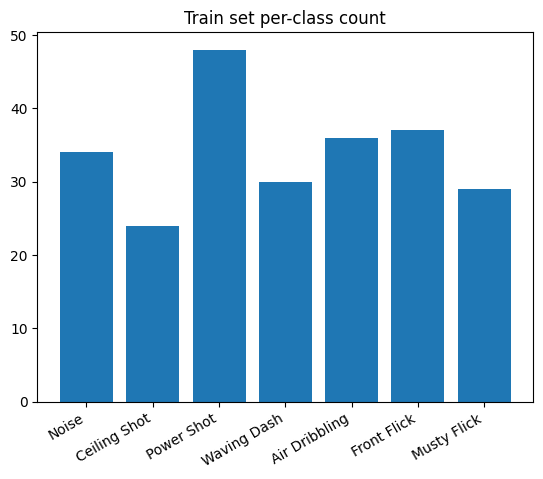

In [12]:
# getting per class counts
hist_data_train = train.groupBy('class').count().sort('class').collect()
# setting label alignment and rotation
ax = plt.gca()
plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')
# plotting the values
plt.title("Train set per-class count")
plt.bar(np.arange(len(ordered_labels)),[i['count'] for i in hist_data_train], tick_label=ordered_labels)

<BarContainer object of 7 artists>

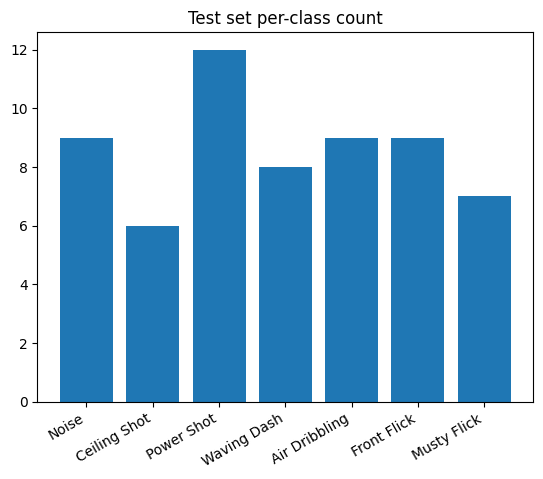

In [7]:
hist_data_test = test.groupBy('class').count().sort('class').collect()
# setting label alignment and rotation
ax = plt.gca()
plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')
# plotting the values
plt.title("Test set per-class count")
plt.bar(np.arange(len(ordered_labels)),[i['count'] for i in hist_data_test], tick_label=ordered_labels)

## Decision Tree

In [47]:
dtc = DecisionTreeClassifier(maxDepth=30, seed=seed, featuresCol='features', labelCol='class')
# apparently 30 is the currently supported maximum depth for pyspark

dtcf = dtc.fit(ttrain)
dtcf.save("./models/decision_tree/base")
predictions = dtcf.transform(ttest)

+----------+-----+
|prediction|class|
+----------+-----+
|       5.0|  5.0|
|       6.0|  6.0|
|       6.0|  6.0|
|       0.0|  6.0|
|       6.0|  6.0|
+----------+-----+
only showing top 5 rows

Accuracy: 
0.7333333333333333
Weighted precision: 
0.8226527149321267
Weighted recall: 
0.7333333333333333


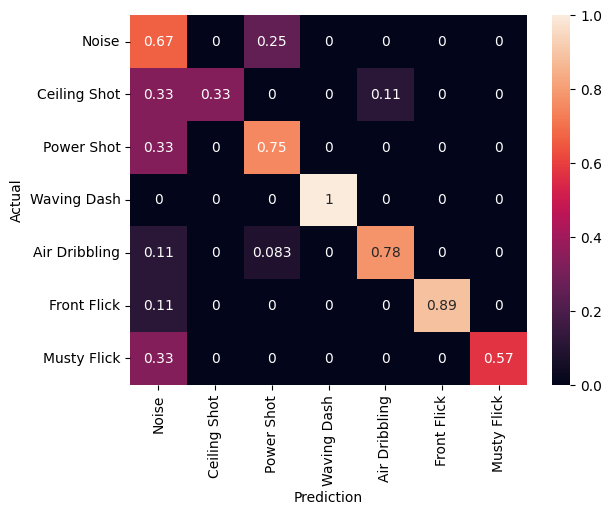

In [49]:
predictions.select("prediction", "class").show(5)
print_metrics(predictions)

In [58]:
dtc_param_grid = ParamGridBuilder()\
                .addGrid(DecisionTreeClassifier.impurity, ['gini', 'entropy'])\
                .addGrid(DecisionTreeClassifier.maxDepth, [i+1 for i in range(3,15)])\# min 3 as it has at least 1 leaf for each class
                .addGrid(DecisionTreeClassifier.minInstancesPerNode, [i+1 for i in range(5)])\
                .addGrid(DecisionTreeClassifier.minInfoGain, [0.1*i for i in range(11)]).build()
dtc_cv = DecisionTreeClassifier(featuresCol='features', labelCol='class',seed=seed)
evaluator =MulticlassClassificationEvaluator(labelCol='class', predictionCol='prediction', metricName='accuracy')
dtc_cross_val = CrossValidator(estimator=dtc_cv,
                              estimatorParamMaps=dtc_param_grid,
                              evaluator=evaluator,
                              numFolds=4,
                              parallelism=2,
                              seed=seed)


In [59]:
dtc_cv_model = dtc_cross_val.fit(train)

14.990741491317749


In [67]:
best_dtc = DecisionTreeClassifier(featuresCol='features', labelCol='class', seed=seed)
epmd = {k.name : v for (k,v) in dtc_cv_model.getEstimatorParamMaps()[np.argmax(dtc_cv_model.avgMetrics)].items()}
best_dtc.setParams(**epmd)
best_dtcf = best_dtc.fit(train)
best_dtcf.save("./models/decision_tree/hyperParameterTuned")
dtc_best_predictions = best_dtcf.transform(test)

+----------+-----+
|prediction|class|
+----------+-----+
|       5.0|    5|
|       6.0|    6|
|       6.0|    6|
|       6.0|    6|
|       6.0|    6|
+----------+-----+
only showing top 5 rows

Accuracy: 
0.7333333333333333
Weighted precision: 
0.8226527149321267
Weighted recall: 
0.7333333333333333


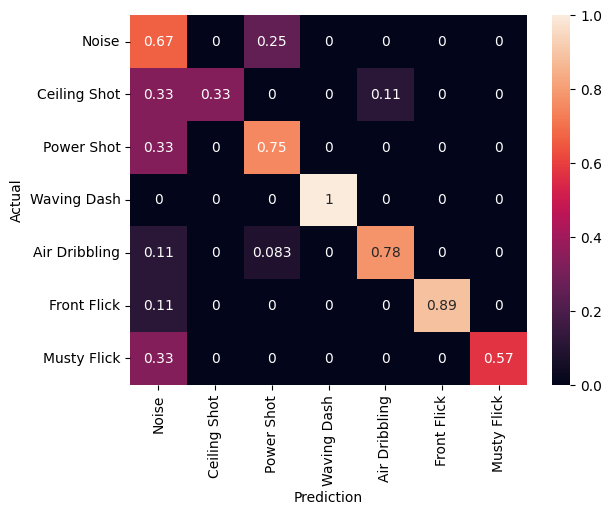

In [68]:
dtc_best_predictions.select("prediction", "class").show(5)
dtc_metrics = print_metrics(dtc_best_predictions)

## Random Forest

In [7]:
rfc = RandomForestClassifier(featuresCol='features',
                             labelCol='class',
                             featureSubsetStrategy='sqrt',
                             maxDepth=30,
                             numTrees=100,
                             seed=seed)

rfcf = rfc.fit(train)
rfcf.save("./models/random_forest/base")
predictions = rfcf.transform(test)

#print(rfc.explainParams())

23/06/07 13:36:47 WARN DAGScheduler: Broadcasting large task binary with size 1287.1 KiB
23/06/07 13:36:47 WARN DAGScheduler: Broadcasting large task binary with size 1562.0 KiB
23/06/07 13:36:48 WARN DAGScheduler: Broadcasting large task binary with size 1758.6 KiB
23/06/07 13:36:48 WARN DAGScheduler: Broadcasting large task binary with size 1607.2 KiB
23/06/07 13:36:49 WARN DAGScheduler: Broadcasting large task binary with size 1203.5 KiB


23/06/07 13:40:07 WARN DAGScheduler: Broadcasting large task binary with size 1403.3 KiB
+-----+----------+
|class|prediction|
+-----+----------+
|    5|       5.0|
|    6|       6.0|
|    6|       6.0|
|    6|       6.0|
|    6|       6.0|
+-----+----------+
only showing top 5 rows

23/06/07 13:40:08 WARN DAGScheduler: Broadcasting large task binary with size 1405.4 KiB
23/06/07 13:40:08 WARN DAGScheduler: Broadcasting large task binary with size 1407.0 KiB


/usr/local/spark-3.3.1-bin-hadoop3/python/pyspark/sql/context.py:157: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


23/06/07 13:40:09 WARN DAGScheduler: Broadcasting large task binary with size 1415.3 KiB


Accuracy: 
23/06/07 13:40:11 WARN DAGScheduler: Broadcasting large task binary with size 1425.6 KiB
0.85
Weighted precision: 
0.8741558441558441
Weighted recall: 
0.8499999999999999


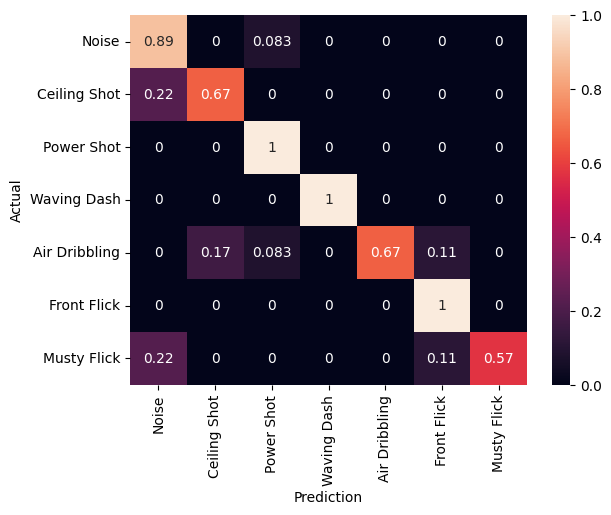

In [13]:
predictions.select('class', 'prediction').show(5)
print_metrics(predictions)

In [ ]:
rfc_param_grid = ParamGridBuilder()\
                .addGrid(RandomForestClassifier.impurity, ['gini', 'entropy'])\
                .addGrid(RandomForestClassifier.maxDepth, [i+1 for i in range(15)])\
                .addGrid(RandomForestClassifier.minInstancesPerNode, [i+1 for i in range(5)])\
                .addGrid(RandomForestClassifier.minInfoGain, [0.1*i for i in range(11)])\
                .addGrid(RandomForestClassifier.featureSubsetStrategy, ['sqrt', 'all', 'log2', 'onethird'])\ #considering only the automatic feature selection
                .addGrid(RandomForestClassifier.numTrees, [20*i for i in range(1,11)])\
                .addGrid(RandomForestClassifier.subsampling, [0.1*i for i in range(11)]).build()
rfc_cv = RandomForestClassifier(featuresCol='features', labelCol='class',seed=seed)
evaluator =MulticlassClassificationEvaluator(labelCol='class', predictionCol='prediction', metricName='accuracy')
rfc_cross_val = CrossValidator(estimator=rfc_cv,
                              estimatorParamMaps=rfc_param_grid,
                              evaluator=evaluator,
                              numFolds=4,
                              parallelism=2,
                              seed=seed)


In [ ]:
rfc_cv_model = rfc_cross_val.fit(train)

In [ ]:
best_rfc = DecisionTreeClassifier(featuresCol='features', labelCol='class', seed=seed)
epmd = {k.name : v for (k,v) in rfc_cv_model.getEstimatorParamMaps()[np.argmax(rfc_cv_model.avgMetrics)].items()}
best_rfc.setParams(**epmd)
best_rfcf = best_rfc.fit(train)
best_rfcf.save("./models/random_forest/hyperParameterTuned")
rfc_best_predictions = best_rfcf.transform(test)

In [ ]:
rfc_best_predictions.select("prediction", "class").show(5)
rfc_metrics = print_metrics(rfc_best_predictions)

## XGBoost

In [7]:
xgb = SparkXGBClassifier(features_col='features', label_col='class', random_state=seed)
print(xgb.explainParams())

arbitrary_params_dict: arbitrary_params_dict This parameter holds all of the additional parameters which are not exposed as the the XGBoost Spark estimator params but can be recognized by underlying XGBoost library. It is stored as a dictionary. (default: {}, current: {'seed': 42})
base_margin_col: This stores the name for the column of the base margin (undefined)
base_score: Refer to XGBoost doc of xgboost.sklearn.XGBClassifier for this param base_score (default: None)
booster: Refer to XGBoost doc of xgboost.sklearn.XGBClassifier for this param booster (default: None)
callbacks: Refer to XGBoost doc of xgboost.sklearn.XGBClassifier.fit() for this param callbacksThe callbacks can be arbitrary functions. It is saved using cloudpickle which is not a fully self-contained format. It may fail to load with different versions of dependencies. (default: None)
colsample_bylevel: Refer to XGBoost doc of xgboost.sklearn.XGBClassifier for this param colsample_bylevel (default: None)
colsample_byn

In [59]:
train.select('class').collect()

[Row(class=6),
 Row(class=0),
 Row(class=0),
 Row(class=0),
 Row(class=0),
 Row(class=6),
 Row(class=1),
 Row(class=7),
 Row(class=1),
 Row(class=6),
 Row(class=2),
 Row(class=1),
 Row(class=7),
 Row(class=6),
 Row(class=2),
 Row(class=1),
 Row(class=2),
 Row(class=1),
 Row(class=0),
 Row(class=5),
 Row(class=5),
 Row(class=5),
 Row(class=5),
 Row(class=5),
 Row(class=6),
 Row(class=5),
 Row(class=5),
 Row(class=5),
 Row(class=6),
 Row(class=7),
 Row(class=1),
 Row(class=5),
 Row(class=6),
 Row(class=6),
 Row(class=2),
 Row(class=6),
 Row(class=7),
 Row(class=7),
 Row(class=7),
 Row(class=7),
 Row(class=7),
 Row(class=7),
 Row(class=7),
 Row(class=7),
 Row(class=7),
 Row(class=7),
 Row(class=7),
 Row(class=7),
 Row(class=7),
 Row(class=7),
 Row(class=7),
 Row(class=7),
 Row(class=7),
 Row(class=2),
 Row(class=2),
 Row(class=2),
 Row(class=2),
 Row(class=2),
 Row(class=2),
 Row(class=2),
 Row(class=2),
 Row(class=1),
 Row(class=1),
 Row(class=1),
 Row(class=1),
 Row(class=1),
 Row(class

## SVM

In [58]:
svm = OneVsRest(classifier=LinearSVC(featuresCol='features',
                             labelCol='class'), featuresCol='features', labelCol='class')
print(svm.explainParams())
svmf = svm.fit(train)
#svmf.save("./models/svm/base")
predictions = svmf.transform(test)
predictions.head()

classifier: base binary classifier (current: LinearSVC_ec1a1f85a6fd)
featuresCol: features column name. (default: features, current: features)
labelCol: label column name. (default: label, current: class)
parallelism: the number of threads to use when running parallel algorithms (>= 1). (default: 1)
predictionCol: prediction column name. (default: prediction)
rawPredictionCol: raw prediction (a.k.a. confidence) column name. (default: rawPrediction)
weightCol: weight column name. If this is not set or empty, we treat all instance weights as 1.0. (undefined)
23/06/23 14:19:22 ERROR Instrumentation: java.lang.IllegalArgumentException: requirement failed: LinearSVC only supports binary classification. 1 classes detected in LinearSVC_ec1a1f85a6fd__labelCol
	at scala.Predef$.require(Predef.scala:281)
	at org.apache.spark.ml.classification.LinearSVC.$anonfun$train$1(LinearSVC.scala:212)
	at org.apache.spark.ml.util.Instrumentation$.$anonfun$instrumented$1(Instrumentation.scala:191)
	at scala.

IllegalArgumentException: requirement failed: LinearSVC only supports binary classification. 1 classes detected in LinearSVC_ec1a1f85a6fd__labelCol